# Exploration 15: Optical Character Recognition
---

#### Data
* [Barnes & Noble's Best Books of 2020](https://www.barnesandnoble.com/b/books/best-books-of-the-year-2020/barnes-nobles-best-books-of-2020/_/N-29Z8q8Z2v0a)
* [Barnes & Noble's Best Books of 2021](https://www.barnesandnoble.com/b/books/barnes-nobles-best-books-of-2021/barnes-nobles-10-best-books-of-2021/_/N-29Z8q8Z2w2h)

#### Goals

1. right OCR usage
2. model evaluation
3. use more than 20 test images and compare the results
---

## Importing Dependencies

In [8]:
import os, glob, re, cv2, io
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import pytesseract
from PIL import Image
from pytesseract import Output
from google.cloud import vision
from PIL import ImageDraw

print("All imported!")

All imported!


## Loading Data

In [9]:
image_dir = os.getenv('HOME') + '/aiffel/ocr_python/bestsellers/'
bestsellers = glob.glob(image_dir+"*.png")
bestsellers

['/aiffel/aiffel/ocr_python/bestsellers/202010.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202009.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202104.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202005.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202107.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202103.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202001.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202004.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202108.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202006.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202008.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202109.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202110.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202102.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202002.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202007.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202106.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202003.png',
 '/aiffel/aiffel/ocr_python/bestsellers/202101

---

## OCR test

### 1. Google OCR API test

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

for bestseller in bestsellers:
    print(f'[{bestseller}]')
    detect_text(os.path.join(image_dir, bestseller))
    print('----------------------------------------------------')

-rw-r--r-- 1 root root 2318 Mar  3 05:06 /aiffel/aiffel/ocr_python/my_google_api_key.json
[/aiffel/aiffel/ocr_python/bestsellers/202010.png]
Texts:

"100 Netable Bosks 2020
A SAGA OF CHURCHILL, FAMILY,
AND DEFIANCE DURING THE BLITZ
THE
SPLENDID
Sook
AND THE
Times
York
VILE
100 Nota
ERIK
LARSON
THE #1 NE W YORK TIMES BESTSELLING AUTHOR OF
THE DEVIL IN THE WHITE CITY AND DEAD WAKE
ence and his style of steady-handed
"A harrowing chronicle...Churchill's lessons of
leadership are essential to the state of mind of American readers"-VANITY FAIR
Bevlew
"

"100"

"Netable"

"Bosks"

"2020"

"A"

"SAGA"

"OF"

"CHURCHILL,"

"FAMILY,"

"AND"

"DEFIANCE"

"DURING"

"THE"

"BLITZ"

"THE"

"SPLENDID"

"Sook"

"AND"

"THE"

"Times"

"York"

"VILE"

"100"

"Nota"

"ERIK"

"LARSON"

"THE"

"#1"

"NE"

"W"

"YORK"

"TIMES"

"BESTSELLING"

"AUTHOR"

"OF"

"THE"

"DEVIL"

"IN"

"THE"

"WHITE"

"CITY"

"AND"

"DEAD"

"WAKE"

"ence"

"and"

"his"

"style"

"of"

"steady-handed"

""A"

"harrowing"

"chronic

### 2. keras_ocr test

In [12]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [13]:
images = [keras_ocr.tools.read(os.path.join(image_dir, bestseller)) for bestseller in bestsellers]
prediction_groups = [pipeline.recognize([os.path.join(image_dir, bestseller)]) for bestseller in bestsellers]

print("done")

done


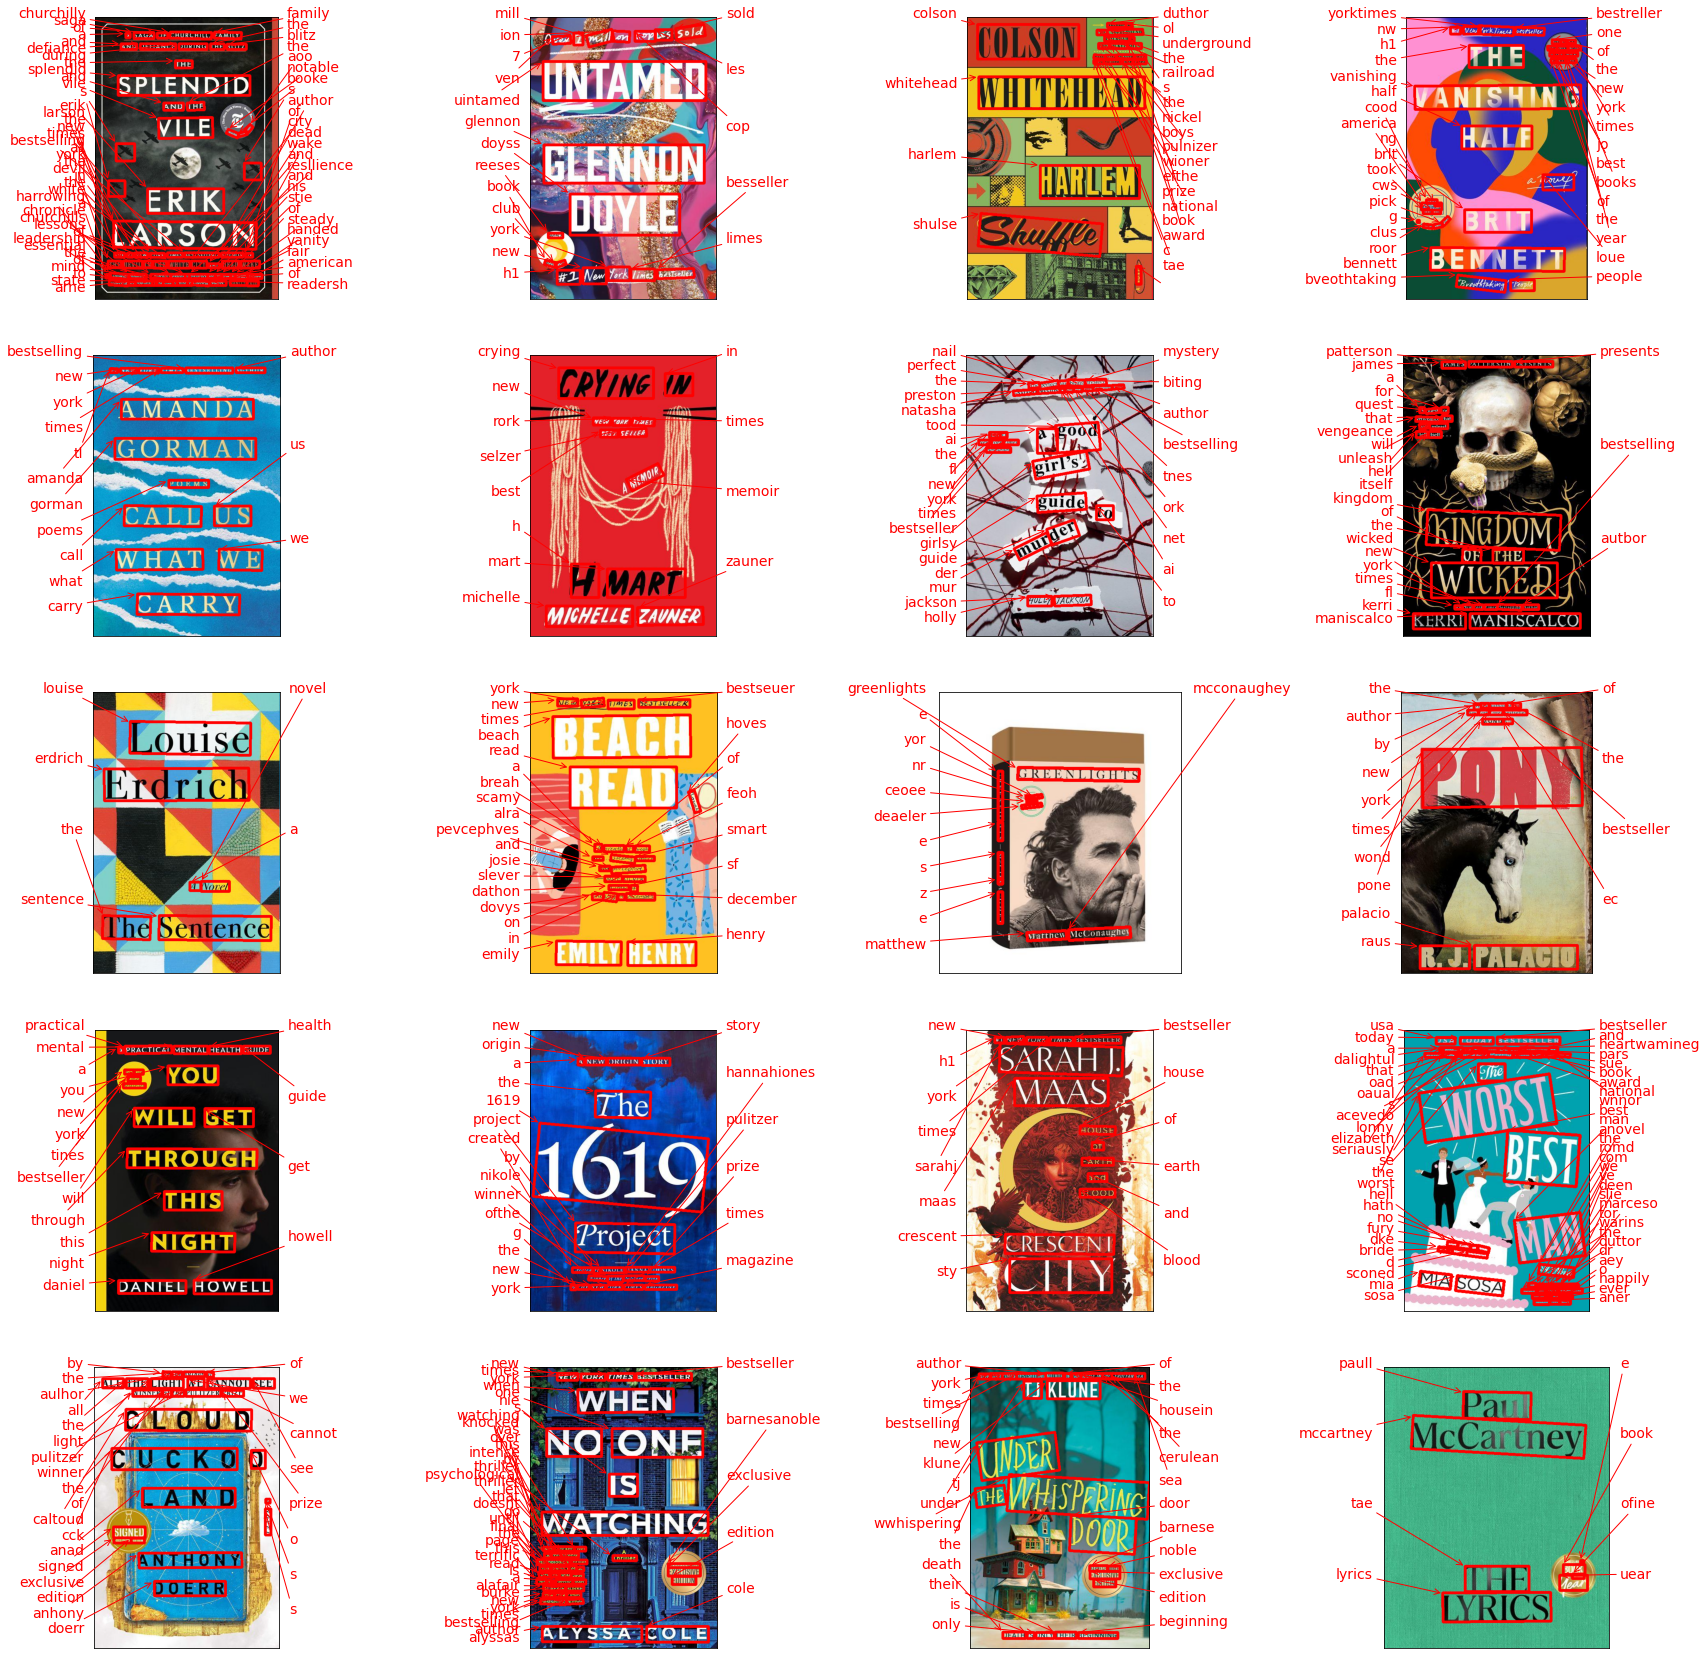

In [14]:
# Plot the predictions
fig, axs = plt.subplots(5, 4, figsize=(30, 30))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=prediction_groups[4*a+b][0], ax=axs[a,b])

### 3. Tesseract test

In [22]:
def detect_box(image_path):
    filename = os.path.basename(image_path)
    # read the image and get the dimensions
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])

    # draw the bounding boxes on the image
    for i in range(n_boxes):
        if int(d['conf'][i]) > 1:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = d['text'][i]
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (0, 0, 255), 3)
    return img

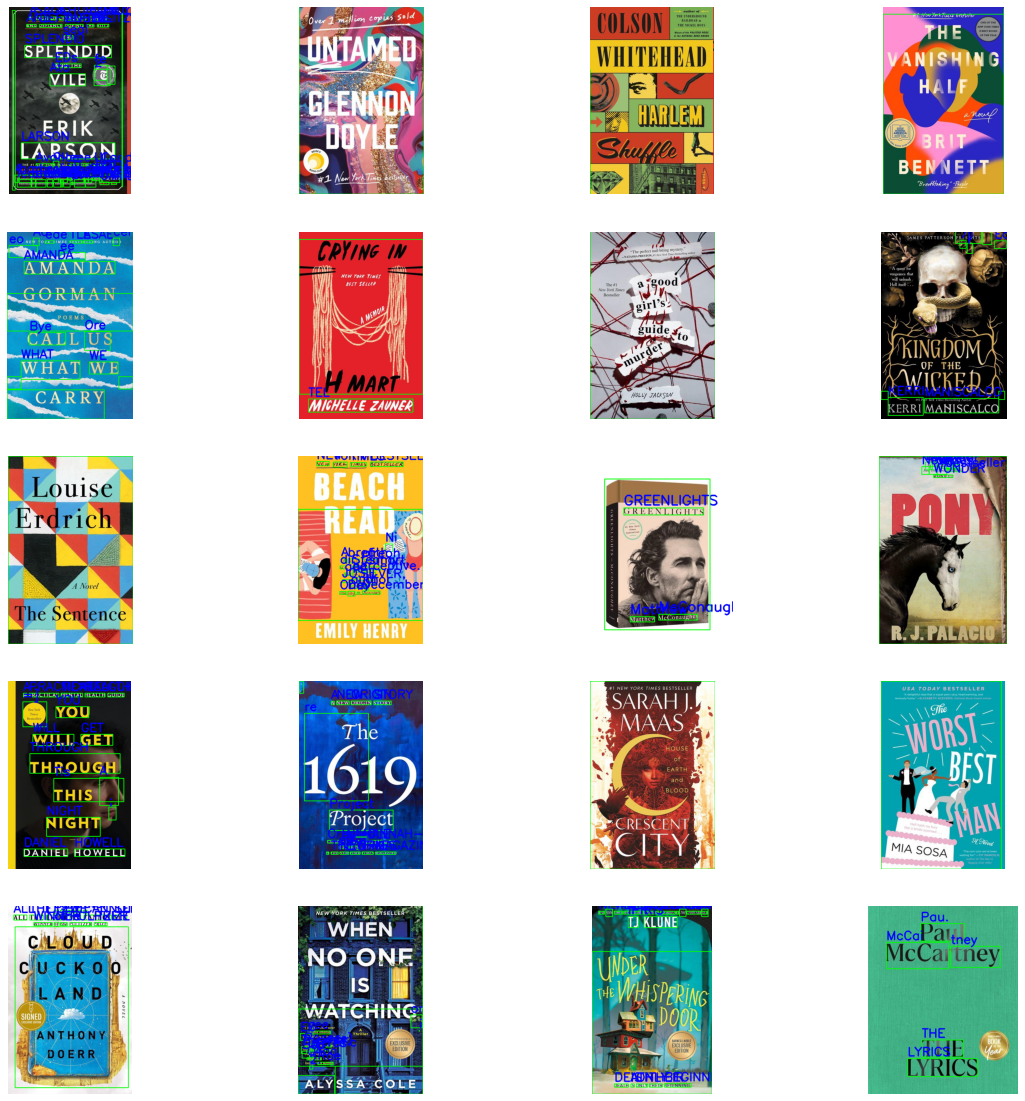

In [29]:
plt.figure(figsize=(20,20))
for i, image_path in enumerate(bestsellers, 1):
    img = detect_box(image_path)
    plt.subplot(5,4,i)
    plt.imshow(img)
    plt.axis('off')

In [23]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
   
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [24]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/bestsellers'
img_file_path = work_dir + '/202101.png'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/bestsellers/0000.png
/aiffel/aiffel/ocr_python/bestsellers/0001.png
/aiffel/aiffel/ocr_python/bestsellers/0002.png
/aiffel/aiffel/ocr_python/bestsellers/0003.png
/aiffel/aiffel/ocr_python/bestsellers/0004.png
/aiffel/aiffel/ocr_python/bestsellers/0005.png
/aiffel/aiffel/ocr_python/bestsellers/0006.png
/aiffel/aiffel/ocr_python/bestsellers/0007.png
/aiffel/aiffel/ocr_python/bestsellers/0008.png
/aiffel/aiffel/ocr_python/bestsellers/0009.png
/aiffel/aiffel/ocr_python/bestsellers/0010.png
/aiffel/aiffel/ocr_python/bestsellers/0011.png
/aiffel/aiffel/ocr_python/bestsellers/0012.png
/aiffel/aiffel/ocr_python/bestsellers/0013.png
/aiffel/aiffel/ocr_python/bestsellers/0014.png
/aiffel/aiffel/ocr_python/bestsellers/0015.png
/aiffel/aiffel/ocr_python/bestsellers/0016.png
/aiffel/aiffel/ocr_python/bestsellers/0017.png
/aiffel/aiffel/ocr_python/bestsellers/0018.png


In [25]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

recognize_images(cropped_image_path_list)

NE Vy

Mig

hae

BESTSELLING

VERE

i

bE AOLUSF

yt

THE

aia ie

SEA

in

Ue

JeFAILH

Ss

ONLY

TREIR

REGCGINNING.

|

Done


## Comparison

### Tesseract

In [34]:
def show_tesseract(num):
    plt.figure(figsize=(20,20))
    
    plt.subplot(121)
    org = cv2.imread(bestsellers[num])
    org = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
    plt.imshow(org)
    plt.title('Original')
    plt.subplot(122)
    img = detect_box(bestsellers[num])
    plt.imshow(img)
    plt.title('Detected')
    txt = recognize_images(cropped_image_path_list)
    print(txt)

NE Vy

Mig

hae

BESTSELLING

VERE

i

bE AOLUSF

yt

THE

aia ie

SEA

in

Ue

JeFAILH

Ss

ONLY

TREIR

REGCGINNING.

|

Done
None


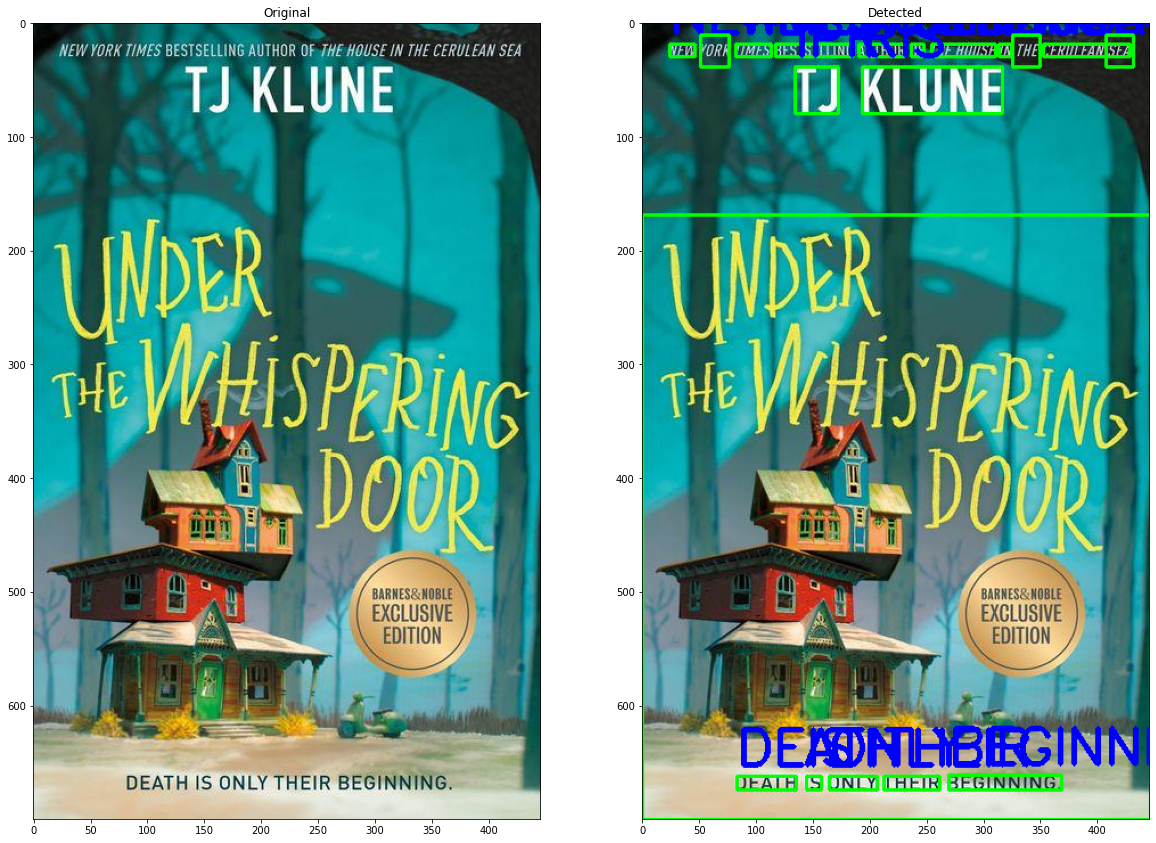

In [39]:
#202101.png
show_tesseract(18)

### Keras-ocr

In [44]:
def show_keras(num):
    keras_ocr.tools.drawAnnotations(image=images[num], predictions=prediction_groups[num][0])

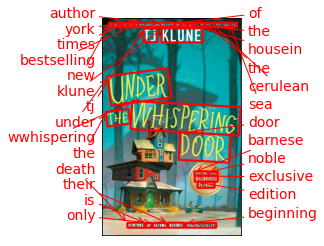

In [46]:
show_keras(18)

### Google OCR

In [47]:
path_202101 = os.getenv('HOME')+'/aiffel/ocr_python/bestsellers/202101.png'
detect_text(path_202101)

Texts:

"NEW YORK TIMES BESTSELLING AUTHOR OF THE HOUSE IN THE CERULEAN SEA
TJ KLUNE
UNDER
HE WHISPERING
DOOR
BARNES&NOBLE
EXCLUSIVE
EDITION
DEATH IS ONLY THEIR BEGINNING.
"

"NEW"

"YORK"

"TIMES"

"BESTSELLING"

"AUTHOR"

"OF"

"THE"

"HOUSE"

"IN"

"THE"

"CERULEAN"

"SEA"

"TJ"

"KLUNE"

"UNDER"

"HE"

"WHISPERING"

"DOOR"

"BARNES&NOBLE"

"EXCLUSIVE"

"EDITION"

"DEATH"

"IS"

"ONLY"

"THEIR"

"BEGINNING."
bounds: (269,659),(367,659),(367,673),(269,673)


---

## Conclusion

As expected, the Google OCR API showed the best result of recognition.<br/>
The books had all different designs of letters but Google OCR was able to detect and recognize most of them.<br/>
Unlike Google, Tesseract showed the worst result.<br/>
Maybe b/c of all the noises such as pictures, unique fonts, etc.<br/>
Also, the Keras-OCR showed reasonable results.<br/>
When words were cramped together or tilted it was able to detect them but some were not properly recognized.<br/>